# TSFRESH Human Activity Recognition Example
This example show shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to exctract useful features from multiple timeseries and use them to improve classification performance.

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from __future__ import absolute_import, division
from urllib.request import urlopen
from zipfile import ZipFile
from pandas import DataFrame
from io import BytesIO
import pandas as pd
import numpy as np
import sys
import os
import logging


In [3]:
# We set the logger to Error level
# This is not recommend for normal use as you can oversee important Warning messages
logging.basicConfig(level=logging.ERROR)

## Load and visualize data
数据集包含7352个sample，每个sample里面是已经提取好的561个特征. UCI:HAR数据集的原始数据采样频率为50Hz，每个传感器的时间窗口是2.56s

In [4]:
_logger = logging.getLogger(__name__)

module_path = '/home/hadoop'
data_file_name = os.path.join(module_path, 'data')
data_file_bodyacc_x_dataset = os.path.join(module_path, 'data', 'UCI HAR Dataset', 'train', 'Inertial Signals','body_acc_x_train.txt')
data_file_bodyacc_y_dataset = os.path.join(module_path, 'data', 'UCI HAR Dataset', 'train', 'Inertial Signals','body_acc_y_train.txt')
data_file_bodyacc_z_dataset = os.path.join(module_path, 'data', 'UCI HAR Dataset', 'train', 'Inertial Signals','body_acc_z_train.txt')
data_file_bodygyro_x_dataset = os.path.join(module_path, 'data', 'UCI HAR Dataset', 'train', 'Inertial Signals','body_gyro_x_train.txt')
data_file_bodygyro_y_dataset = os.path.join(module_path, 'data', 'UCI HAR Dataset', 'train', 'Inertial Signals','body_gyro_y_train.txt')
data_file_bodygyro_z_dataset = os.path.join(module_path, 'data', 'UCI HAR Dataset', 'train', 'Inertial Signals','body_gyro_z_train.txt')
data_file_totalacc_x_dataset = os.path.join(module_path, 'data', 'UCI HAR Dataset', 'train', 'Inertial Signals','total_acc_x_train.txt')
data_file_totalacc_y_dataset = os.path.join(module_path, 'data', 'UCI HAR Dataset', 'train', 'Inertial Signals','total_acc_y_train.txt')
data_file_totalacc_z_dataset = os.path.join(module_path, 'data', 'UCI HAR Dataset', 'train', 'Inertial Signals','total_acc_z_train.txt')

data_file_name_classes = os.path.join(module_path, 'data', 'UCI HAR Dataset', 'train', 'y_train.txt')

data_path=[data_file_bodyacc_x_dataset, data_file_bodyacc_y_dataset, data_file_bodyacc_z_dataset,
          data_file_bodygyro_x_dataset, data_file_bodygyro_y_dataset, data_file_bodygyro_z_dataset,
          data_file_totalacc_x_dataset, data_file_totalacc_y_dataset, data_file_totalacc_z_dataset]

sensor_path={'body_acc_x':data_file_bodyacc_x_dataset, 
             'body_acc_y':data_file_bodyacc_y_dataset, 
             'body_acc_z':data_file_bodyacc_z_dataset, 
             'body_gyro_x':data_file_bodygyro_x_dataset, 
             'body_gyro_y':data_file_bodygyro_y_dataset, 
             'body_gyro_z':data_file_bodygyro_z_dataset, 
             'total_acc_x':data_file_totalacc_x_dataset, 
             'total_acc_y':data_file_totalacc_y_dataset, 
             'total_acc_z':data_file_totalacc_z_dataset}

def download_har_dataset():
    zipurl = 'https://github.com/MaxBenChrist/human-activity-dataset/blob/master/UCI%20HAR%20Dataset.zip?raw=true'

    if os.path.exists(data_file_bodyacc_x_dataset) and os.path.exists(data_file_name_classes):
        _logger.warning("You have already downloaded the Human Activity Data Set.")
        return

    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(path=data_file_name)
        zfile.close()

def load_har_dataset(sensor_list, sampling):
    sensor_data={}
    try:
        for i in range(len(sensor_list)):
            tmp_data=np.loadtxt(sensor_path[sensor_list[i]])
            tmp_sample=tmp_data[:,0:64]            
            sensor_data[sensor_list[i]]=tmp_sample[:,::sampling]
            
        return sensor_data
    except IOError:
        raise IOError('File {} was not found. Have you downloaded the dataset with download_har_dataset() '
                      'before?'.format(data_file_name_dataset))
        
def load_har_feature_name():
    try:
        return pd.read_csv(data_file_name_features, delim_whitespace=True, header=None)
    except IOError:
        raise IOError('File {} was not found. Have you downloaded the dataset with download_har_dataset() '
                      'before?'.format(data_file_name_dataset))

def load_har_classes():
    try:
        return pd.read_csv(data_file_name_classes, delim_whitespace=True, header=None, squeeze=True)
    except IOError:
        raise IOError('File {} was not found. Have you downloaded the dataset with download_har_dataset() '
                      'before?'.format(data_file_name_classes))
        
def getHar(num=1000):
    df = load_har_dataset()[:num]
    featurename=load_har_feature_name()[:num]
    featurename=featurename.ix[:,1]
    return df, featurename

In [59]:
# 六个传感器数据
# sensor=["body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z"]
sensor=["body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z"]

# 一些常量，这里不需要filenum，文件数量是根据sensor的数量走的
sensornum=len(sensor)
#窗口步长大小
sampling=1      #建议选择2的倍数
win=128
step=64      #步长应该小于等于win

In [60]:
#根据Win，生成DataFrame格式中的Time列
def getTimeColumn(win):
    time=np.arange(win)
    for idx in range(1, sensornum):
        timetmp=np.arange(win)
        time=np.concatenate((time, timetmp), axis=0)
    time.shape=(len(time),1)
    return time

#根据Win和数据，生成DataFrame格式中的kind和value列
def getKindValueColumn(sd, win):
    for i in range(sensornum):
        kind=i*np.ones((win, 1),dtype=int)
        sensorcols=sd[i]
        sensorcols.shape=(win, 1)
        sdata=np.column_stack((kind, sensorcols))
        if i==0:
            sensorframe=sdata
        else:
            sensorframe=np.row_stack((sensorframe, sdata))
    return sensorframe

def getIdColumn(win, count):
    return count*np.ones((win*sensornum, 1))

In [61]:
def showIndex(intro="", i="", label="", fixed_row="", fixed_num="", start_row="", start_idx="", end_row="", end_idx=""):
    print("\n"+intro)
    print("i: "+ str(i))
    print("label: "+ str(label))
    print("fixed_row:"+str(fixed_row))
    print("fixed_num:"+str(fixed_num))
    print("start_row:"+str(start_row))
    print("start_idx:"+str(start_idx))
    print("end_row:"+str(end_row))
    print("end_idx:"+str(end_idx))

def getHarData(har_data, sampling, win, step, use_num):
    y = load_har_classes(); 
    sensor_data=har_data
    max_row=len(sensor_data[sensor[0]]); max_column=sensor_data[sensor[0]].shape[1]
    print(str(max_row))
    print(str(max_column))
              
    if step<=win:
        fixed_row=0; fixed_num=0; label=[];
        for i in range(use_num):
            sd=[]
            start_row=fixed_row + int(step*(i-fixed_num)/max_column)
            end_row=fixed_row + int((step*(i-fixed_num)+win)/max_column) if (step*(i-fixed_num)+win)%max_column!=0 \
                                                                else fixed_row + int((step*(i-fixed_num)+win)/max_column)-1    #这一行是能取到的
            if end_row<max_row:
                if y[start_row]==y[end_row]:
                    start_idx=(step*(i-fixed_num))%max_column
                    end_idx=max_column if (step*(i-fixed_num)+win)%max_column==0 else (step*(i-fixed_num)+win)%max_column    #这个end_idx是比能访问的idx多1的，取不到
#                     showIndex("if:", i, fixed_row, fixed_num, start_row, start_idx, end_row, end_idx)
                else:
                    while 1:
#                         showIndex("if:", i, label[i], fixed_row, fixed_num, start_row, start_idx, end_row, end_idx)
                        if y[start_row]==y[start_row+1]:
                            start_row+=1
                        else:
                            start_row+=1
                            fixed_row=start_row; fixed_num=i
                            end_row=fixed_row + int((step*(i-fixed_num)+win)/max_column) if (step*(i-fixed_num)+win)%max_column!=0 \
                                                                else fixed_row + int((step*(i-fixed_num)+win)/max_column)-1
                            start_idx=0
                            end_idx=max_column if (step*(i-fixed_num)+win)%max_column==0 else (step*(i-fixed_num)+win)%max_column    #这个end_idx是比能访问的idx多1的，取不到
#                             showIndex("while:", i, label[i], fixed_row, fixed_num, start_row, start_idx, end_row, end_idx)
                            break
            else:
                print('\033[1;33;48mNote:the real \'use_num\' is '+ str(i))
                break
            
            for j in range(sensornum):
                for row in range(start_row, end_row + 1):
                    for column in range(max_column):
                        if row==start_row:
                            if start_row!=end_row:
                                if column>=start_idx:
                                    sd.append(sensor_data[sensor[j]][row, column])
                            elif column>=start_idx and column<end_idx:
                                sd.append(sensor_data[sensor[j]][row, column])
                        elif row!=start_row and row!=end_row:
                            sd.append(sensor_data[sensor[j]][row, column])
                        elif row==end_row and column<end_idx:
                            sd.append(sensor_data[sensor[j]][row, column])                    
            
            label.append(y[start_row])  
#             showIndex("for down:", i, label[i], fixed_row, fixed_num, start_row, start_idx, end_row, end_idx)

            sd=np.array(sd); sd.shape=(len(sd), 1); sd=sd.reshape(-1, win)

            time=getTimeColumn(win)
            kindvalue=getKindValueColumn(sd, win)
            idary=getIdColumn(win, i)
            actionary=np.column_stack((idary,time, kindvalue ))
            
            if i == 0:
                dataarray=actionary
            else:
                dataarray=np.concatenate((dataarray, actionary), axis=0)
        label=pd.Series(label)
        return dataarray, label
    else:
        raise IOError('\'step\' of slide window shoud be less than \'win\'')

In [62]:
# fetch dataset from uci
download_har_dataset()

har_data=load_har_dataset(sensor, sampling)
max_row=len(har_data[sensor[0]]); max_column=har_data[sensor[0]].shape[1]
                                                            
print('\033[1;33;48mNote: you can try the max \'use_num\': '+ str(int((max_column*max_row-win)/step+1)) 
      + "\n"+"But the real \'use_num\' may be less than it ")

Note: you can try the max 'use_num': 7351
But the real 'use_num' may be less than it 


In [75]:
# df, featurename=getHar()
#使用的样本数量(一个窗口的数据是一个样本)，建议设置陈6的倍数
use_num=600

data, label=getHarData(har_data, sampling, win, step, use_num)

master_df= DataFrame(data, columns=['id', 'time', 'kind', 'value'])

print(data)
# print(master_df)
# print(label.shape)

7352
64
[[  0.00000000e+00   1.20000000e+02   0.00000000e+00   6.02460100e-05]
 [  0.00000000e+00   1.21000000e+02   0.00000000e+00   4.35422500e-04]
 [  0.00000000e+00   1.22000000e+02   0.00000000e+00  -8.18533800e-04]
 [  0.00000000e+00   1.23000000e+02   0.00000000e+00   2.27655500e-04]
 [  0.00000000e+00   1.24000000e+02   0.00000000e+00  -2.99893800e-04]
 [  0.00000000e+00   1.25000000e+02   0.00000000e+00  -1.14748400e-03]
 [  0.00000000e+00   1.26000000e+02   0.00000000e+00  -2.22265500e-04]
 [  0.00000000e+00   1.27000000e+02   0.00000000e+00   1.57550000e-03]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   1.07668100e-02]
 [  0.00000000e+00   1.00000000e+00   1.00000000e+00   6.57948000e-03]
 [  0.00000000e+00   2.00000000e+00   1.00000000e+00   8.92887800e-03]
 [  0.00000000e+00   3.00000000e+00   1.00000000e+00   7.48868300e-03]
 [  0.00000000e+00   4.00000000e+00   1.00000000e+00   6.14096600e-03]
 [  0.00000000e+00   5.00000000e+00   1.00000000e+00   6.94431700e-03

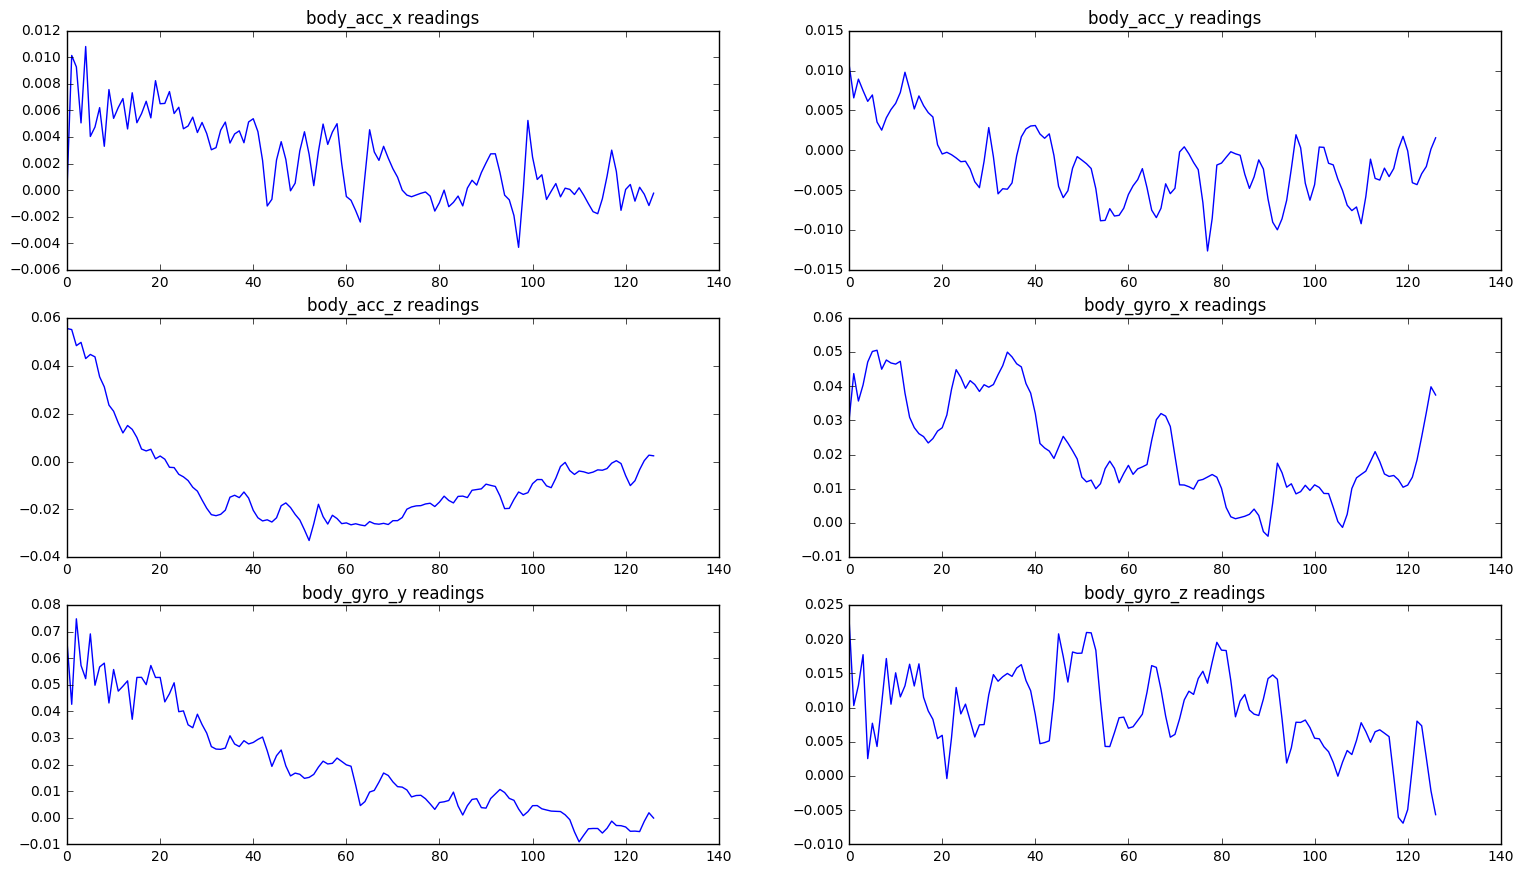

In [65]:
#画出第idx个样本六个传感器的数据
def plotSample(data, idx, win):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    for i in range(sensornum):
        plt.subplot(3,2,i+1)
        plt.title(sensor[i] + ' readings')
        begin=idx*win*sensornum + win*i
        end=begin+win-1
        plt.plot(data[begin:end, 3])
    plt.show()

#展示sensor数据，第idx条数据的传感器读数，注意这里的纵轴范围还没有统一，不能直接跨样本对比
kind=sensor[0]; idx=0
plotSample(data, idx, win)

In [66]:
X=master_df
# X.columns=list(featurename)

In [67]:
# in total we have transformed the sensor data into 222 features
X.shape

(460800, 4)

In [68]:
# extraction_settings = ComprehensiveFCParameters()
# extraction_settings = EfficientFCParameters()
extraction_settings = MinimalFCParameters()

%time X = extract_features(master_df, default_fc_parameters=extraction_settings, column_id='id', column_sort="time", column_kind="kind", column_value="value");

Feature Extraction: 100%|██████████| 6/6 [00:01<00:00,  2.91it/s]

CPU times: user 116 ms, sys: 25.7 ms, total: 141 ms
Wall time: 1.92 s


In [69]:
impute(X)
X.columns

Index([u'0.0__maximum', u'0.0__length', u'0.0__mean',
       u'0.0__standard_deviation', u'0.0__minimum', u'0.0__sum_values',
       u'0.0__variance', u'0.0__median', u'1.0__median', u'1.0__mean',
       u'1.0__variance', u'1.0__length', u'1.0__sum_values',
       u'1.0__standard_deviation', u'1.0__minimum', u'1.0__maximum',
       u'3.0__sum_values', u'3.0__variance', u'3.0__standard_deviation',
       u'3.0__length', u'3.0__minimum', u'3.0__mean', u'3.0__median',
       u'3.0__maximum', u'2.0__maximum', u'2.0__length', u'2.0__mean',
       u'2.0__minimum', u'2.0__median', u'2.0__standard_deviation',
       u'2.0__sum_values', u'2.0__variance', u'4.0__sum_values',
       u'4.0__standard_deviation', u'4.0__maximum', u'4.0__minimum',
       u'4.0__variance', u'4.0__length', u'4.0__median', u'4.0__mean',
       u'5.0__sum_values', u'5.0__standard_deviation', u'5.0__mean',
       u'5.0__maximum', u'5.0__minimum', u'5.0__variance', u'5.0__length',
       u'5.0__median'],
      dtype='objec

## Train and evaluate classifier

In [70]:
y = label

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [72]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.89      1.00      0.94        17
          2       1.00      0.94      0.97        18
          3       1.00      0.93      0.97        15
          4       0.55      0.61      0.58        18
          5       0.62      0.64      0.63        28
          6       0.76      0.67      0.71        24

avg / total       0.78      0.78      0.78       120



# Multiclass feature selection

In [55]:
relevant_features = set()

for label in y.unique():
    y_train_binary = y_train == label
    print(type(X_train))
    print(type(y_train_binary))
    X_train_filtered = select_features(X_train, y_train_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Number of relevant features for class 5: 528/561
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Number of relevant features for class 4: 531/561
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Number of relevant features for class 6: 534/561
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Number of relevant features for class 1: 527/561
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Number of relevant features for class 3: 532/561
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Number of relevant features for class 2: 542/561


In [56]:
len(relevant_features)

556

so, we reduced the number of used features from 222 to 98

In [57]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.94      0.93      0.94       245
          2       0.93      0.89      0.91       209
          3       0.91      0.96      0.93       187
          4       0.95      0.89      0.92       256
          5       0.91      0.95      0.93       291
          6       1.00      1.00      1.00       283

avg / total       0.94      0.94      0.94      1471



Unfortunately, the quality of the predictor worsen a little bit

## Compare against naive classification accuracy
By extracting using time-series features (as opposed to using raw data points), we can meaningfully increase classification accuracy.

In [58]:
X_1 = X.ix[:use_num,:]
X_1.shape

(7352, 561)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=.2)

In [60]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.96      0.93      0.95       259
          2       0.92      0.92      0.92       212
          3       0.90      0.94      0.92       206
          4       0.91      0.92      0.91       233
          5       0.93      0.92      0.92       262
          6       1.00      0.99      1.00       299

avg / total       0.94      0.94      0.94      1471



So, both our unfiltered and filtered feature based classificators are able to beat the model on the raw time series values 